# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [98]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [99]:
download = 1 # Set "download = None" if you have not already downloaded the files

In [100]:
if download is None:
    # URLs for the dataset files
    data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
    data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
    data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

    def download_file(url, file_name):
        response = requests.get(url)
        response.raise_for_status()
        with open(file_name, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded {file_name}')

    # Download the files
    download_file(data_train_features_url, 'X_train.pkl')
    download_file(data_train_labels_url, 'y_train.pkl')
    download_file(data_test_features_url, 'X_test.pkl')

In [101]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[          0     0.65987     0.57177     0.10944     0.16268]]


## Data Visualization

Display sample images with bounding boxes.

In [102]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

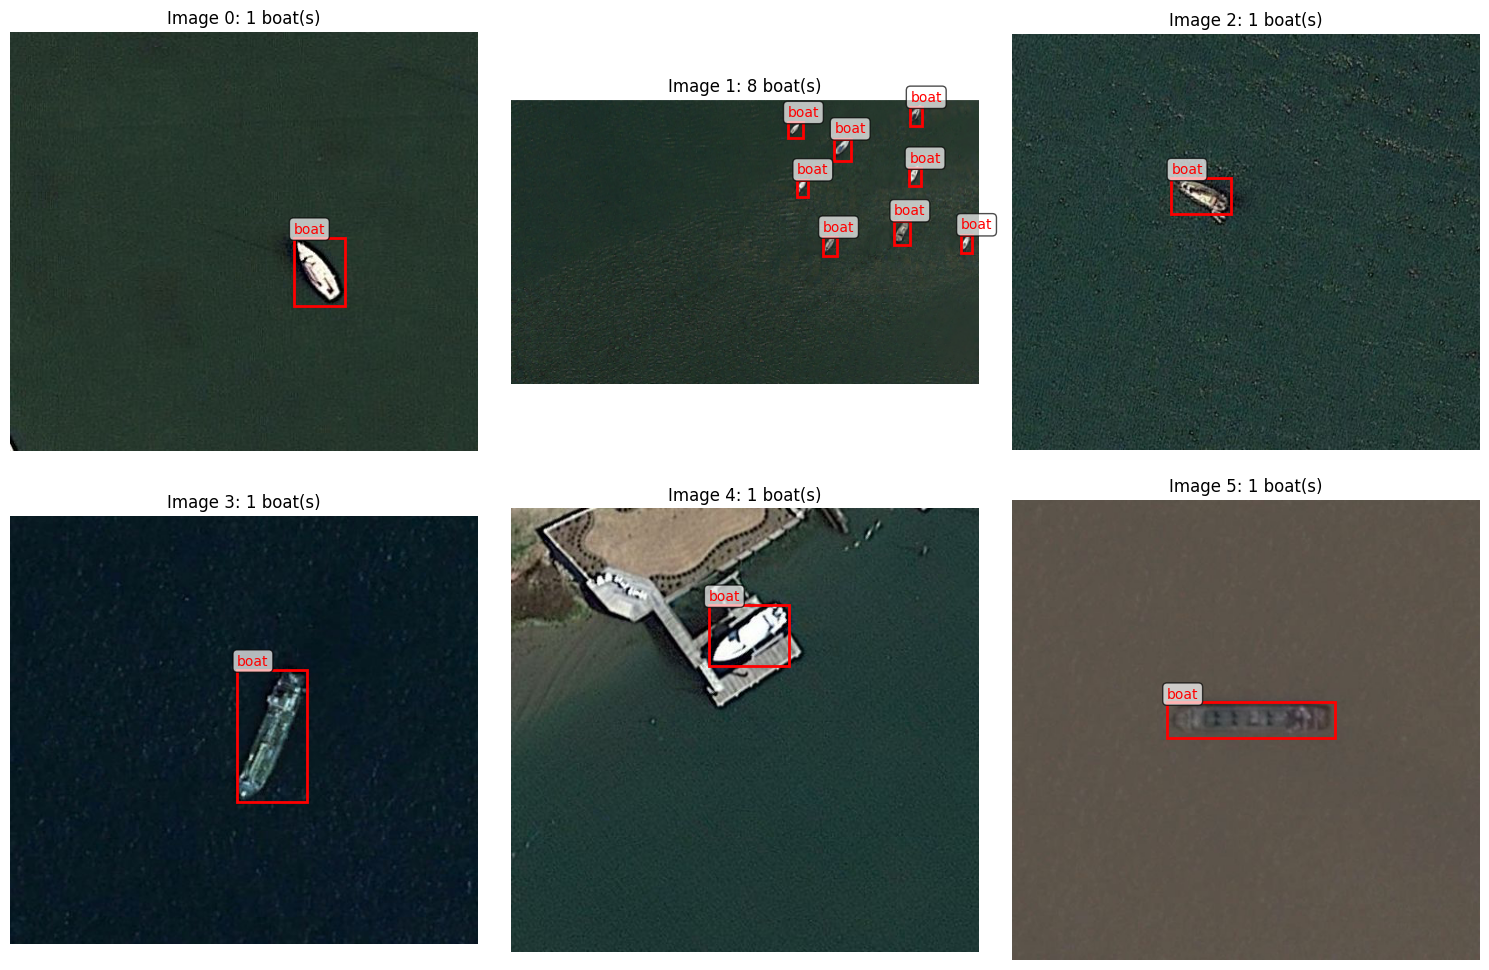

In [103]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [104]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Model loaded successfully!


In [105]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 c:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\hugojava\module7\temp_sample.png: 576x640 1 tennis racket, 1304.2ms
Speed: 403.2ms preprocess, 1304.2ms inference, 275.5ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [106]:
# Your code here
# Fine-tune the YOLO model

### Train Test Split

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Creation of the files to be able to use the mAP50 metric

In [108]:
import os
import cv2
import yaml
import numpy as np

# === Configurations ===
# Tes données déjà chargées :
# X_train, y_train, X_val, y_val
# y_* = liste (ou array) de listes [label, x_center, y_center, height, width]
# toutes les coordonnées sont déjà normalisées entre 0 et 1

# Noms des classes
class_names = ['boat']  # ➜ change si tu as plusieurs classes

# Dossier de sortie
base_dir = "dataset_boats"
os.makedirs(base_dir, exist_ok=True)

# Sous-dossiers
splits = {
    "train": (X_train, y_train),
    "val": (X_val, y_val)
}

# === Sauvegarde images et labels ===
for split, (X, y) in splits.items():
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    print(f"\n➡️ Sauvegarde des données {split} ({len(X)} images) ...")

    for i, (img, labels) in enumerate(zip(X, y)):
        # Sauvegarde image
        img_path = os.path.join(img_dir, f"img_{i}.jpg")
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        # Sauvegarde labels (format YOLO)
        label_path = os.path.join(label_dir, f"img_{i}.txt")
        with open(label_path, "w") as f:
            for lab in np.atleast_2d(labels):  # gérer le cas 1 seule bbox
                cls, x, y_, h, w_ = lab
                f.write(f"{int(cls)} {x:.6f} {y_:.6f} {w_:.6f} {h:.6f}\n")

print("\n✅ Images et labels sauvegardés avec succès !")

# === Création du fichier data.yaml ===
data_yaml = {
    "train": os.path.abspath(os.path.join(base_dir, "train/images")),
    "val": os.path.abspath(os.path.join(base_dir, "val/images")),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = os.path.join(base_dir, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"\n✅ Fichier data.yaml créé : {yaml_path}")
print("\nContenu du fichier :")
print(yaml.dump(data_yaml, default_flow_style=False))


➡️ Sauvegarde des données train (396 images) ...

➡️ Sauvegarde des données val (100 images) ...

✅ Images et labels sauvegardés avec succès !

✅ Fichier data.yaml créé : dataset_boats\data.yaml

Contenu du fichier :
names:
- boat
nc: 1
train: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\train\\images"
val: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\val\\images"



In [109]:
# Evaluate the Pre-trained model on the validation set
metrics_pre_trained = model.val(data='dataset_boats/data.yaml', verbose=False)

print(f"mAP@0.5: {metrics_pre_trained.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics_pre_trained.box.map:.3f}")
print(f"Precision: {metrics_pre_trained.box.mp:.3f}")
print(f"Recall: {metrics_pre_trained.box.mr:.3f}")

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 191.789.8 MB/s, size: 53.7 KB)
val: Scanning C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGénéral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 14.1Kit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.1it/s 47.5s2.9ss
                   all        100        160      0.306       0.05       0.07     0.0226
Speed: 41.9ms preprocess, 363.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\runs\detect\val11
mAP@0.5: 0.070
mAP@0.5:0.95: 0.023
Precision: 0.306
Recall: 0.050


### Fine-tuning

In [110]:
# Réentraîner sur le dataset de bateaux
model.train(
    data='dataset_boats/data.yaml',
    epochs=10,          # nombre d'époques (à ajuster)
    imgsz=640,          # taille des images
    batch=16,           # taille du batch
    name='boat_yolov8n' # nom du dossier de sortie
)

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)


KeyboardInterrupt: 

In [ ]:
metrics = model.val(data='dataset_boats/data.yaml', verbose=False)
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

In [ ]:
results = model.predict(source='temp_sample.png', conf=0.25)
results[0].show()  # Affiche les bounding boxes

## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [ ]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [ ]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model.predict(source='temp_test.png', conf=0.25, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 68


(1, 5)


<Axes: >

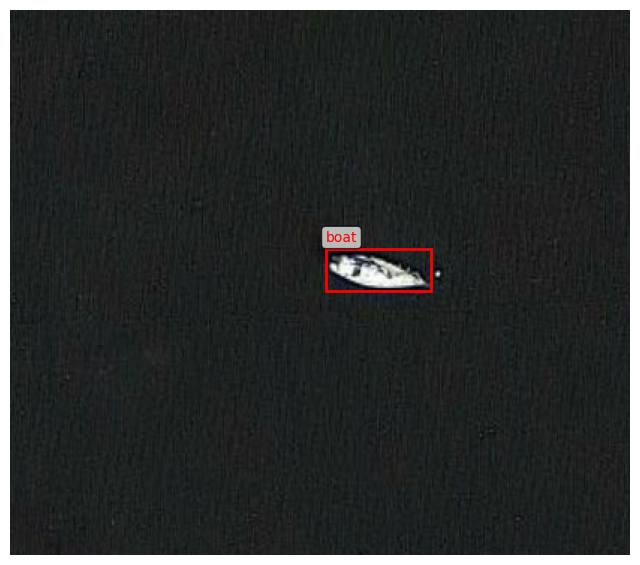

In [ ]:
# first image of the test set
pred_0 = predictions[0]
image_0 = X_test[pred_0["image_id"]]
box_0 = np.array([pred_0["class_id"], pred_0["x_center"], pred_0["y_center"], pred_0["width"], pred_0["height"]]).reshape(1,-1)
print(box.shape)
plot_image_with_boxes(image_0, box_0)

In [ ]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         8        0         0    0.441250  0.592931  0.475514  0.169875   
1         9        0         0    0.326024  0.554065  0.525330  0.205861   
2        13        0         0    0.273208  0.271222  0.482766  0.270190   
3        15        0         0    0.492731  0.484478  0.414104  0.126098   
4        16        0         0    0.425013  0.454327  0.388593  0.241952   
5        16        1         0    0.298281  0.454746  0.389681  0.242045   
6        18        0         0    0.261670  0.223757  0.348427  0.131816   
7        19        0         0    0.390121  0.440069  0.414793  0.213702   
8        21        0         0    0.681832  0.551698  0.612663  0.187439   
9        26        0         0    0.494986  0.509390  0.487086  0.076486   

     height  
0  0.076654  
1  0.280519  
2  0.209556  
3  0.383791  
4  0.279050  
5  0.280721  
6  0